Importing basic Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns',500)
import datetime
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn')

Reading data and formatting datetime data

In [2]:
gram_dataset = pd.read_csv('600002-10days.csv',usecols=['timestamp','b_phase_current','y_phase_current','r_phase_current'])
gram_dataset['timestamp'] = gram_dataset.timestamp.apply(lambda x: datetime.datetime.strptime(x,'%d-%m-%Y %H:%M'))
initial_t = gram_dataset['timestamp'][0]
new_timestamp = []
new_timestamp.append(initial_t)
for t in gram_dataset['timestamp'][1:]:
    if t == initial_t:
        initial_t = t
        t+=datetime.timedelta(seconds = 30)
        new_timestamp.append(t)
    else:
        initial_t = t
        new_timestamp.append(t)

gram_dataset['timestamp'] = new_timestamp
# gram_dataset.set_index('timestamp').resample('60S').mean()

basic info like sample data, shape and info

In [3]:
gram_dataset.head()

b_phase_current  r_phase_current           timestamp  y_phase_current
0           12.540            0.580 2018-10-01 00:00:00             0.46
1           12.565            0.580 2018-10-01 00:00:30             0.46
2           12.616            6.731 2018-10-01 00:01:00             0.46
3           12.616            7.251 2018-10-01 00:01:30             0.46
4           12.610            7.173 2018-10-01 00:02:00             0.46

In [4]:
gram_dataset.shape

(28629, 4)

In [5]:
gram_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28629 entries, 0 to 28628
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   b_phase_current  28629 non-null  float64       
 1   r_phase_current  28629 non-null  float64       
 2   timestamp        28629 non-null  datetime64[ns]
 3   y_phase_current  28629 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 894.8 KB


View of the dataset on timeseries

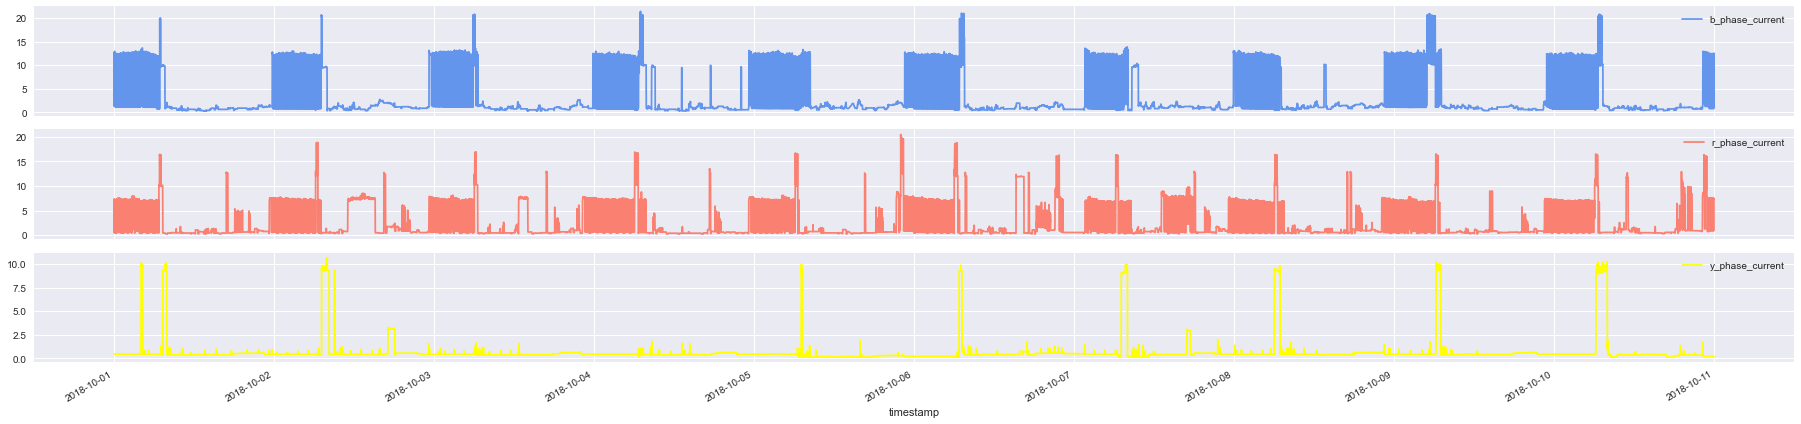

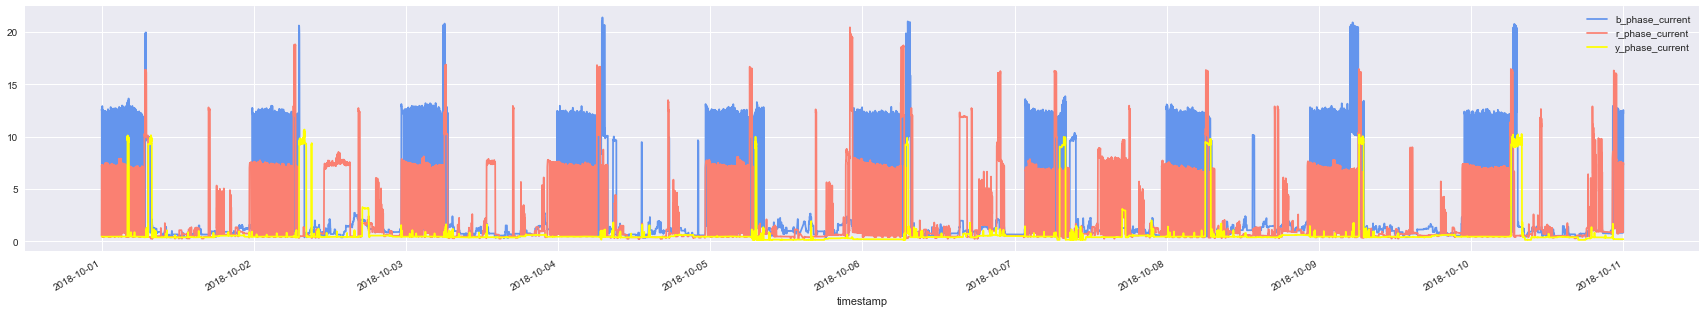

In [6]:

gram_dataset.set_index('timestamp').plot(figsize=(25,6),subplots=True,color = ['cornflowerblue','salmon','yellow'])
plt.tight_layout()
plt.show()
gram_dataset.set_index('timestamp').plot(figsize=(30,5),color = ['cornflowerblue','salmon','yellow'])
plt.show()

closer look on b-phase-current

In [7]:
fig = px.line(gram_dataset, x = 'timestamp',y = 'b_phase_current',title = 'b Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True)
fig.show()

Smoothing data 

In [8]:
df = gram_dataset.set_index('timestamp').resample('T').median().reset_index()
df1 = df.rolling(30).median()
df1.bfill(inplace=True)
df1['timestamp'] = df['timestamp']

View of the smooth data

In [9]:
# df = gram_dataset.set_index('timestamp').resample('5T').median().reset_index()
# df1 = df.rolling(5).mean()
# df1
fig = px.line(df1, x = 'timestamp',y = 'b_phase_current',title = 'b Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True)
fig.show()
# gram_dataset.set_index('timestamp').resample('60S').mean().plot(subplots=True)

In [10]:
start_b = df1['b_phase_current'][0]
start_r = df1['r_phase_current'][0]
start_y = df1['y_phase_current'][0]
new_b_phase_current = []
new_r_phase_current = []
new_y_phase_current = []
for bpc,rpc,ypc in (df1.iloc[:,:3]).values:
    new_b_phase_current.append(bpc-start_b)
    start_b = bpc
    new_r_phase_current.append(rpc-start_r)
    start_r = rpc
    new_y_phase_current.append(ypc-start_y)
    start_y = ypc
df1['new_b_phase_current'] = new_b_phase_current
df1['new_r_phase_current'] = new_r_phase_current
df1['new_y_phase_current'] = new_y_phase_current

In [11]:
fig = px.line(df1, x = 'timestamp',y = 'b_phase_current',title = 'b Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True)
fig.show()

fig = px.line(df1, x = 'timestamp',y = 'r_phase_current',title = 'b Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True)
fig.show()

fig = px.line(df1, x = 'timestamp',y = 'new_b_phase_current',title = 'b differnce of Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True)
fig.show()

We can also consider the threshold differnce between appliance that we assumed to smooth the data,, but for now we didn't considered it yet

and we found in 10 days of data the 6 appliances that we are going to consider is running over 95 times in total, if we consider threshold value of change.

In [17]:
st = df1.new_b_phase_current[0]
c=0
for b_val in df1.new_b_phase_current:
    if abs(b_val-st) < 2:
        # print("No Change")
        st = b_val
    else:
        print("change")
        c+=1
        st = b_val
print(c)

change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
95


Identifying number of appliances based on cluster

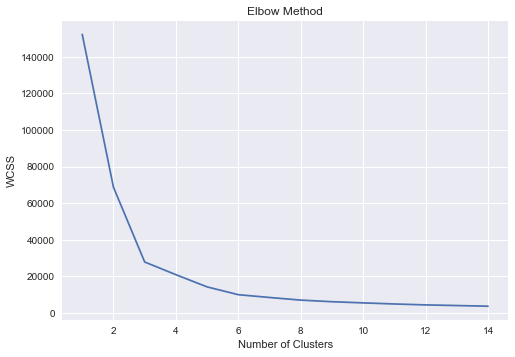

In [13]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i,init = 'k-means++', random_state =0)
    kmeans.fit(df1[['b_phase_current','r_phase_current']])
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,15),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Number of appliances turns out to be 6

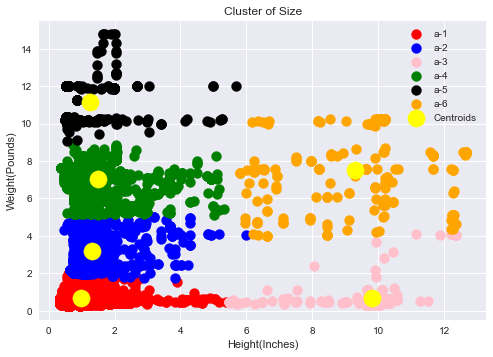

In [14]:
features = df1[['b_phase_current','r_phase_current']]
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 0)
y_means = kmeans.fit_predict(features)

features = np.array(features)
plt.scatter(features[y_means == 0,0], features[y_means == 0,1], s = 100, c= 'red', label = 'a-1')
plt.scatter(features[y_means == 1,0], features[y_means == 1,1], s = 100, c= 'blue', label = 'a-2')
plt.scatter(features[y_means == 2,0], features[y_means == 2,1], s = 100, c= 'pink', label = 'a-3')
plt.scatter(features[y_means == 3,0], features[y_means == 3,1], s = 100, c= 'green', label = 'a-4')
plt.scatter(features[y_means == 4,0], features[y_means == 4,1], s = 100, c= 'black', label = 'a-5')
plt.scatter(features[y_means == 5,0], features[y_means == 5,1], s = 100, c= 'orange', label = 'a-6')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s = 300,c = 'yellow',label = 'Centroids')
plt.title('Cluster of Size')
plt.xlabel('Height(Inches)')
plt.ylabel('Weight(Pounds)')
plt.legend()
plt.show()

In [15]:
df1['labels'] = y_means

In [16]:
fig = px.line(df1, x = 'timestamp',y = 'labels',title = 'b differnce of Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True)
fig.show()

Missing one important thing the switching status or ON/OFF status will be very helpful to identify change between the appliances